In [94]:
from scipy.stats import expon
import random

def simulate_distributed_db(mean_time_of_incoming_request, mean_time_by_db, prob_of_picking_db, size):
    assert(sum(prob_of_picking_db) == 1)
    assert(len(mean_time_by_db) ==  len(prob_of_picking_db))
    def calculate_dbs_turn():
        rand = random.random()
        i = 0
        accumulated_prob = prob_of_picking_db[i]
        while accumulated_prob < rand:
            i += 1
            accumulated_prob += prob_of_picking_db[i]
        return i
    
    def free_at(old_free_at, current_time, time_taken):
        return max(old_free_at, current_time) + time_taken
    
    gonna_be_free_at = [0, 0]
    waiting_times_sum = 0
    requests_that_waited_extra = 0
    
    incoming_requests_delta = expon.rvs(scale=mean_time_of_incoming_request, size=size)
    times_to_process_request_not_scaled = expon.rvs(size=size)
    
    time = 0
    for income_delta, process_time_not_scaled in zip(incoming_requests_delta, times_to_process_request_not_scaled):
        time += income_delta
        dbs_turn = calculate_dbs_turn()
        process_time = process_time_not_scaled * mean_time_by_db[dbs_turn]
        new_free_time_of_db = free_at(gonna_be_free_at[dbs_turn], time, process_time)
        total_waiting_time = new_free_time_of_db - time
        gonna_be_free_at[dbs_turn] = new_free_time_of_db
        waiting_times_sum += total_waiting_time
        has_to_wait_extra = (total_waiting_time > process_time + 0.00001) # Delta de seguridad
        if has_to_wait_extra:
            requests_that_waited_extra += 1
    return waiting_times_sum/size, float(requests_that_waited_extra)/size
        
    

print (simulate_distributed_db(4, [0.7, 1], [0.6, 0.4], 100000))

print (simulate_distributed_db(4, [0.8], [1], 100000))

(0.91213753254353414, 0.10178)
(1.0046152659931213, 0.20006)


In [95]:
# No es recomendable usar la opcion distribuida

# Ejercicio 2


1. 
Suponiendo que esto es modelable por una cadena de Markov (es decir que el proceso es discretizable y que la probabilidad de llegar a un estado es solo dependiente del estado anterior), que las probabilidades dadas son independientes, que el servidor puede tener infinitas solicitudes pendientes, que una solicitud no puede ser resuelta en el mismo intervalo en el que llega y que no puede suceder que dos solicitudes lleguen o se resuelvane en un paso, la matriz de transición sera:

        r      p       0       0   ...
       
 P =  r*q   r*s+p*q   p*s      0   ...
       
        0     r*q   r*s+p*q   p*s  ...
       
       .       .       .       .    . 
        
       .       .       .       .    . 
       
       .       .       .       .   . 
       
 
 
 
 siend p = 1/30, q = 1/40, r = 1 - p y s = 1 - q
 
Esta matriz se obtiene definiendo a cada posible estado como la cantidad de solicitudes en proceso. Dado esto, la matriz puede ser pensada en 2 etapas.

Por un lado, si tenemos mas de una solicitud pendiente, la probabilidad de que tengamos una solicitud menos pendiente en el siguiente estado es igual a la probabilidad de que una solicitud se procese y no llegue otra; como pedimos que estos eventos sean independientes la probabilidad de esto sera igual al producto de la probabilidad de estos eventos, es decir r*q. Por otro lado, para que en el siguiente estado haya una solicitud pendiente más lo que debe suceder es que llegue una solicitud pero que ninguna haya sido procesada, por lo que la probabilidad sera p*s. Finalmente, para mantenernos en el mismo estado debe suceder que se procese una solicitud y llegue otra o que ninguna de estas dos cosas suceda, por lo que la probabilidad sera r*s+p*q. Como se puede observar, y es esperable, la suma de las probabilidades de todas las transiciones es 1.

Por otro lado, si no hay solicitudes pendientes, la probabilidad de tener una solicitud en el siguiente estado es igual a la probabilidad de que llegue una solicitud, ya que son eventos equivalentes; y la probabilidad de seguir teniendo 0 solicitudes es la probabilidad es igual a uno menos la anterior probabilidad.

2.



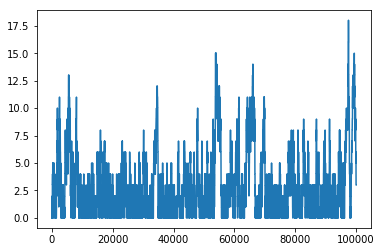

In [96]:
def request_processed():
    return random.random() < 1.0/30
    
def incoming_request():
    return random.random() < 1.0/40

steps = int(1000 / 0.01)

pending_requests = 0
states = []
for i in range(steps):
    states.append(pending_requests)
    if pending_requests > 0 and request_processed():
        pending_requests -= 1
    
    if pending_requests < 29 and incoming_request():
        pending_requests += 1

plt.plot(states)
plt.show()

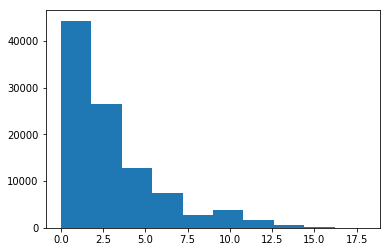

In [97]:
plt.hist(states)
plt.show()

In [98]:
times_without_request = len(filter(lambda x: x == 0, states))

print ('{}%'.format(float(times_without_request)/len(states)*100))

24.683%


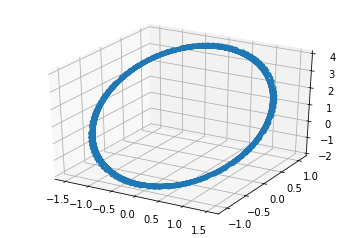

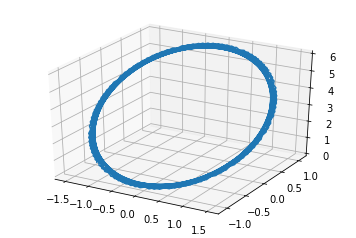

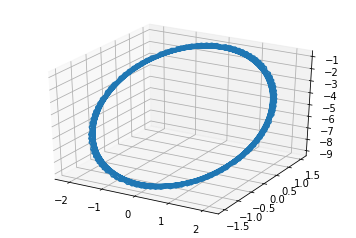

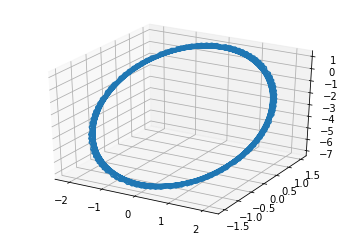

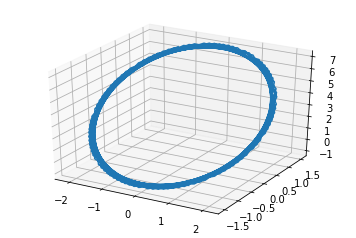

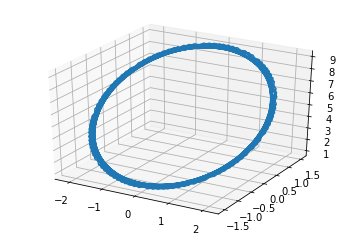

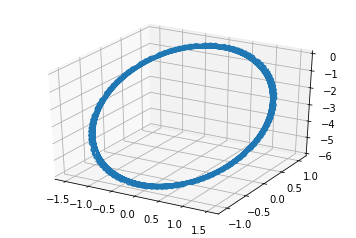

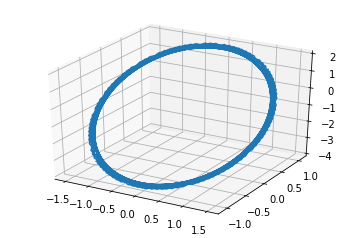

In [99]:


# Ejercicio 3
from mpl_toolkits.mplot3d import Axes3D

def calculate_new_state(x,y,z):
    return x/2 + y, y - x/2, z - x - y

x_seeds = [-1.0, 1.0]
y_seeds = [-1.0, 1.0]
z_seeds = [-1.0, 1.0]

for x_seed in x_seeds:
    for y_seed in y_seeds:

        for z_seed in z_seeds:
            x =  x_seed
            xs = [x]
            y = y_seed
            ys = [y]
            z = z_seed
            zs = [z]
            for i in range(100):
                x, y, z = calculate_new_state(x,y,z)
                xs.append(x)
                ys.append(y)
                zs.append(z)
                
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xs,ys,zs)

            fig.show()
                


# Puntos fijos

Tienen que cumplir las ecuaciones

2 x = x + 2 y

y  = y - x/2

z = z - x -x

=> despejando =>


0 = -x + 2 y


0 = -x/2

0 = - x - y



=> despejando =>

x = 0; y = 0; z puede ser cualquier cosa 

=> Los puntos de equilibrio del sistema se encuentran en el   eje z



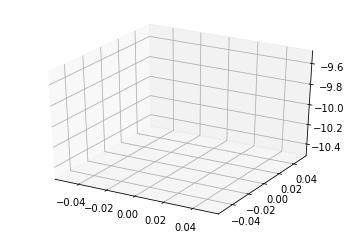

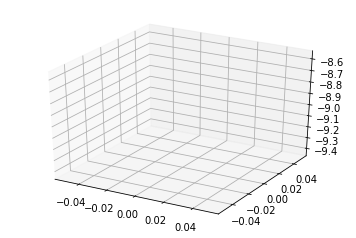

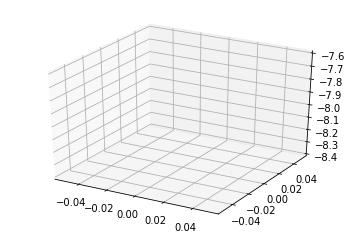

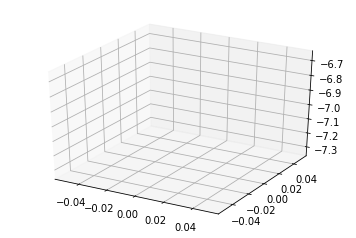

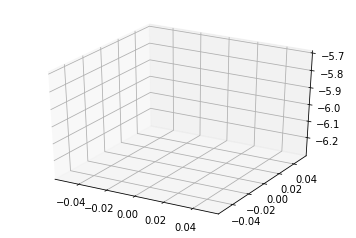

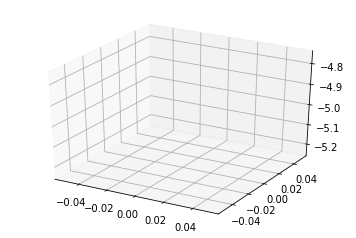

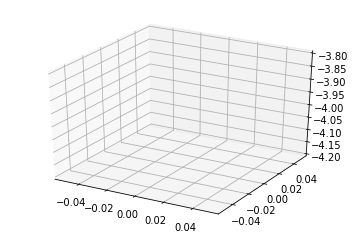

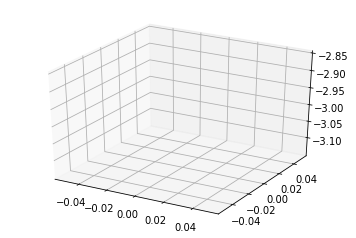

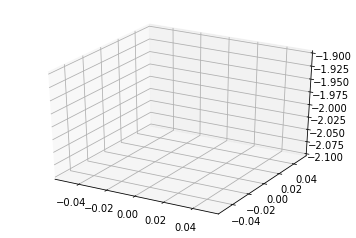

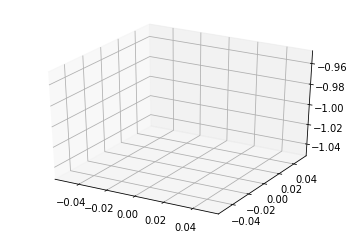

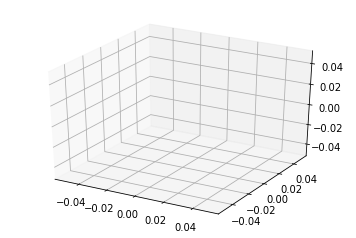

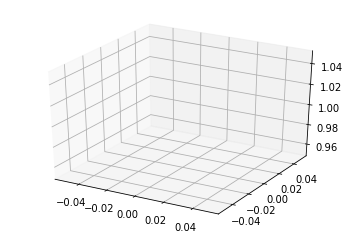

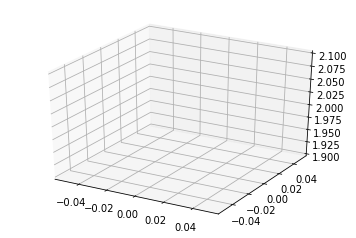

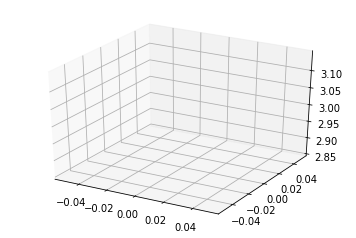

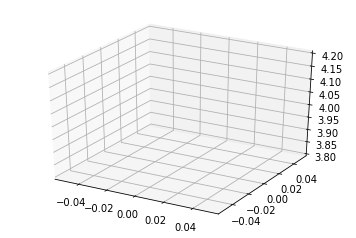

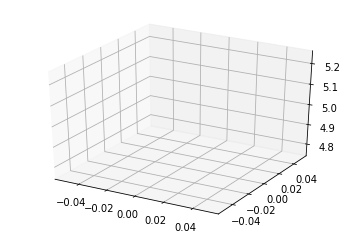

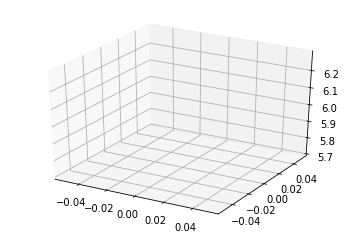

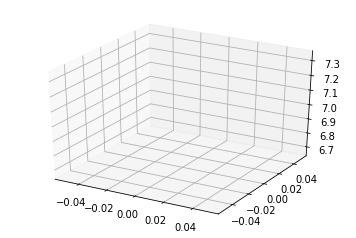

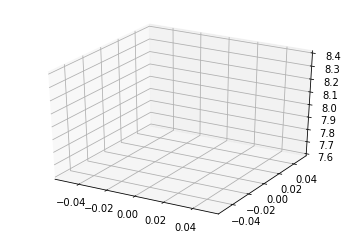

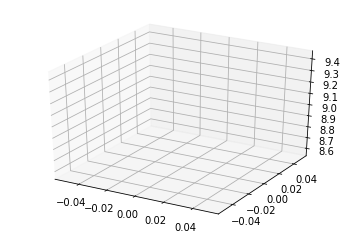

In [100]:
#Compruebo lo enunciado antes
def calculate_new_state(x,y,z):
    return x/2 + y, y - x/2, z - x - y

x_seeds = [0.0]
y_seeds = [0.0]
z_seeds = range(-10, 10)

for x_seed in x_seeds:
    for y_seed in y_seeds:
        for z_seed in z_seeds:
            x =  x_seed
            xs = [x]
            y = y_seed
            ys = [y]
            z = z_seed
            zs = [z]
            for i in range(100):
                x, y, z = calculate_new_state(x,y,z)
                xs.append(x)
                ys.append(y)
                zs.append(z)
                
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xs,ys,zs)

            fig.show()